## Lab 03 Part 3: Taking the default model in the lab 3 part 1 example (or if question 2 was completed the best model for question 2), apply several regularization techniques, re-run the target group analysis, and discuss and findings. 



### Task: Import and Read Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy import*
from sklearn import*

# sklearn 10FCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split

# Keras
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

seed = 1
np.random.seed(seed)

plt.rcParams["figure.figsize"] = (15,5)

### Task: Data Pre-processing

In [3]:
# Opening the file from github
data_o = pd.read_csv("adult.csv")

# Used to label encode categorical values
labelencoder = LabelEncoder()
data_o.replace('?', np.nan, inplace=True)
data_o.dropna(inplace=True)

data = data_o.copy()
print("\n\nColumn Names & formatting:\n")
for col in data_o.columns.values.tolist():
    if data_o[col].dtype == "object" or data_o[col].dtype == "bool":
        print("{:<30}".format(col), ":", "{:<30}".format(str(data[col].dtype)) , "Formatting to LabelEncoding")
        data[col] = labelencoder.fit_transform(data[col])
    else:
        print("{:<30}".format(col), ":", "{:<30}".format(str(data[col].dtype)) , "No formatting required.")


array = data.values
X = array[:,0:14]
Y = array[:,14]



Column Names & formatting:

age                            : int64                          No formatting required.
workclass                      : object                         Formatting to LabelEncoding
fnlwgt                         : int64                          No formatting required.
education                      : object                         Formatting to LabelEncoding
education.num                  : int64                          No formatting required.
marital.status                 : object                         Formatting to LabelEncoding
occupation                     : object                         Formatting to LabelEncoding
relationship                   : object                         Formatting to LabelEncoding
race                           : object                         Formatting to LabelEncoding
sex                            : object                         Formatting to LabelEncoding
capital.gain                   : int64                        

### Task: Data Preparation

In [4]:
# We are using stratification here, this startifies based on class values. 
X_train, X_test, Y_train, Y_test  = train_test_split(X, Y, test_size=0.33, random_state=seed, shuffle = True, stratify=(Y))


# Examine the class breakdown per dataset:
print("Training dataset length:", len(X_train))
print("Testing dataset length:", len(X_test))

class1TrainingPer = np.count_nonzero(Y_train == 1) / len(X_train)
class1TestPer = np.count_nonzero(Y_test == 1) / len(X_test)

print("\nPercentage of 1's in Training data: ", round(class1TrainingPer*100,2), "%")
print("Percentage of 1's in Test data    : ", round(class1TestPer*100,2), "%")

Training dataset length: 20208
Testing dataset length: 9954

Percentage of 1's in Training data:  24.89 %
Percentage of 1's in Test data    :  24.89 %


### Function define

In [5]:
# definition to provide plot and accuracy
def plot_acc_loss(results):
  plt.subplot(1,2,1)
  # summarize history for loss
  plt.plot(results.history['loss'])
  plt.plot(results.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.subplot(1,2,2)
  plt.plot(results.history['acc'])
  plt.plot(results.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('acc')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [6]:
# definition to provide the metrics
def subMetrics(targetGroup, act, pred):
  print("Metrics for: ", targetGroup)
  print("Total instances in the test set:", len(pred))  
  correct = 0
  # parse both lists to numpy arrays"
  act = np.array(act)
  pred = np.array(pred)
  # There may be an easier way to do this, however, I believe it is a manual process!
  for index, item in enumerate(act):  
    if item == pred[index]:
      correct += 1
  # print accuracy, and the confusion matrix
  accuracy = round((correct / len(act)) * 100,2) 
  print("Accuracy:", accuracy, "%")
  print(pd.crosstab( np.array(act),  np.array(pred), rownames=['Actual'], colnames=['Predicted'], margins=True))
  print("\n")

### Task: Bias and Weight Initialization

#### Weight Initialization

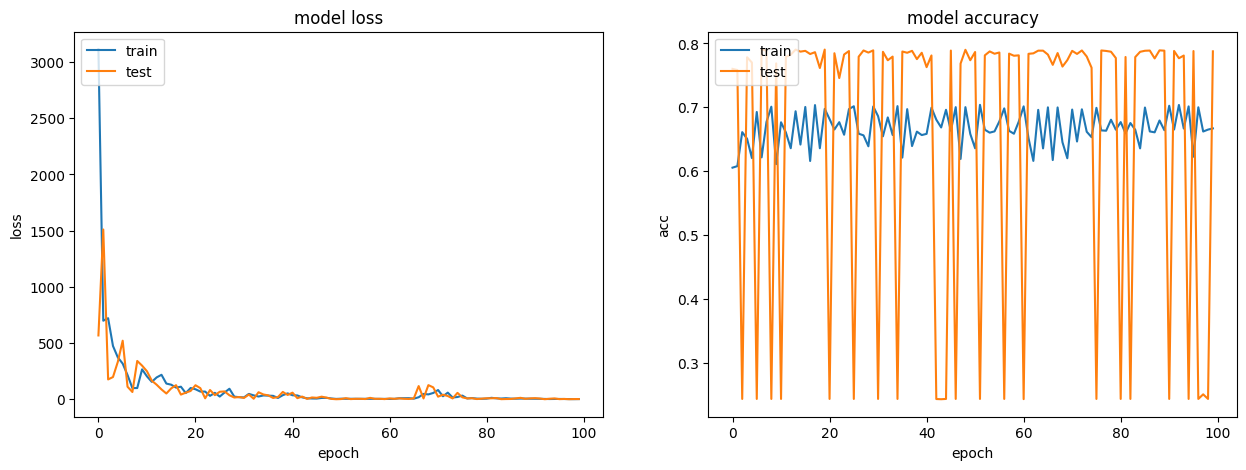

312/312 [==============================] - 1s 3ms/step - loss: 2.3370 - acc: 0.7873
Acuracy:  0.7873216867446899
Predicted     0    1   All
Actual                    
0          7382   94  7476
1          2023  455  2478
All        9405  549  9954


In [7]:
# Need to rerun seed for each DL cell
tf.random.set_seed(seed)

model = Sequential()
model.add(Dense(1000, input_dim=14, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])
results = model.fit(X_train, Y_train, validation_split=0.33, epochs=100, batch_size=1000, verbose=0, shuffle=True)
plot_acc_loss(results)

dl_y_pred = (model.predict(X_test) > 0.5).astype("int32")
dl_y_pred = dl_y_pred.flatten()

print("Acuracy: ", model.evaluate(X_test,Y_test)[1])
print(pd.crosstab(Y_test, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

##### Task: Target Group Bias

In [8]:
# Example for sex target groups  
female_pred = []      # Female was label encoded as 0
female_actual_class = []
male_pred = []        # Male was label encoded as 1
male_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[9] == 0:       # Female
        female_pred.append(dl_y_pred[index])
        female_actual_class.append(Y_test[index])
    elif row[9] == 1:     # Male
        male_pred.append(dl_y_pred[index])
        male_actual_class.append(Y_test[index])

# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
subMetrics("Female", female_actual_class, female_pred)
subMetrics("Male", male_actual_class, male_pred)

Metrics for:  Female
Total instances in the test set: 3244
Accuracy: 89.61 %
Predicted     0    1   All
Actual                    
0          2832   33  2865
1           304   75   379
All        3136  108  3244


Metrics for:  Male
Total instances in the test set: 6710
Accuracy: 73.47 %
Predicted     0    1   All
Actual                    
0          4550   61  4611
1          1719  380  2099
All        6269  441  6710




In [9]:
# Target groups of 'race' 
## {[White : 4], [Black : 2], [Asian : 1], [Indian : 0], [Other : 3]}
white_pred = []      
white_actual_class = []
black_pred = []       
black_actual_class = []
asian_pred = []       
asian_actual_class = []
indian_pred = []       
indian_actual_class = []
other_pred = []       
other_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[8] == 4:       # Female
        white_pred.append(dl_y_pred[index])
        white_actual_class.append(Y_test[index])
    elif row[8] == 2:     # Male
        black_pred.append(dl_y_pred[index])
        black_actual_class.append(Y_test[index])
    elif row[8] == 1:     # Male
        asian_pred.append(dl_y_pred[index])
        asian_actual_class.append(Y_test[index])
    elif row[8] == 0:     # Male
        indian_pred.append(dl_y_pred[index])
        indian_actual_class.append(Y_test[index])
    elif row[8] == 3:     # Male
        other_pred.append(dl_y_pred[index])
        other_actual_class.append(Y_test[index])

# Confusion Matrix:
subMetrics("White", white_actual_class, white_pred)
subMetrics("Black", black_actual_class, black_pred)
subMetrics("Asian", asian_actual_class, asian_pred)
subMetrics("Indian", indian_actual_class, indian_pred)
subMetrics("Other", other_actual_class, other_pred)

Metrics for:  White
Total instances in the test set: 8604
Accuracy: 77.55 %
Predicted     0    1   All
Actual                    
0          6258   90  6348
1          1842  414  2256
All        8100  504  8604


Metrics for:  Black
Total instances in the test set: 885
Accuracy: 89.49 %
Predicted    0   1  All
Actual                 
0          773   1  774
1           92  19  111
All        865  20  885


Metrics for:  Asian
Total instances in the test set: 302
Accuracy: 74.83 %
Predicted    0   1  All
Actual                 
0          209   1  210
1           75  17   92
All        284  18  302


Metrics for:  Indian
Total instances in the test set: 88
Accuracy: 88.64 %
Predicted   0  1  All
Actual               
0          75  2   77
1           8  3   11
All        83  5   88


Metrics for:  Other
Total instances in the test set: 75
Accuracy: 92.0 %
Predicted   0  1  All
Actual               
0          67  0   67
1           6  2    8
All        73  2   75




#### Normal Distribution Weight Initializers

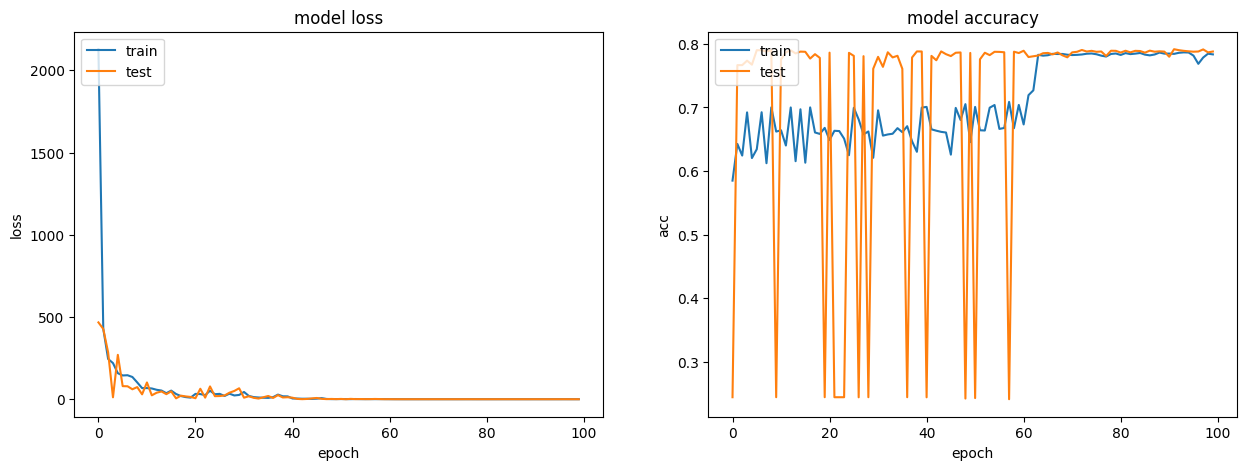

312/312 [==============================] - 1s 3ms/step - loss: 0.5151 - acc: 0.7918
Acuracy:  0.7918424606323242
Predicted     0     1   All
Actual                     
0          7152   324  7476
1          1748   730  2478
All        8900  1054  9954


In [10]:
tf.random.set_seed(seed)

model = Sequential()
model.add(Dense(1000, input_dim=14, activation='relu', kernel_initializer="GlorotNormal"))
model.add(Dense(100, activation='relu', kernel_initializer="GlorotNormal"))
model.add(Dense(100, activation='relu' , kernel_initializer="GlorotNormal"))
model.add(Dense(50, activation='relu', kernel_initializer="GlorotNormal"))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])
results = model.fit(X_train, Y_train, validation_split=0.33, epochs=100, batch_size=1000, verbose=0, shuffle=True)
plot_acc_loss(results)

dl_y_pred = (model.predict(X_test) > 0.5).astype("int32")
dl_y_pred = dl_y_pred.flatten()

print("Acuracy: ", model.evaluate(X_test,Y_test)[1])
print(pd.crosstab(Y_test, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

##### Target Group

In [11]:
# Example for sex target groups  
female_pred = []      # Female was label encoded as 0
female_actual_class = []
male_pred = []        # Male was label encoded as 1
male_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[9] == 0:       # Female
        female_pred.append(dl_y_pred[index])
        female_actual_class.append(Y_test[index])
    elif row[9] == 1:     # Male
        male_pred.append(dl_y_pred[index])
        male_actual_class.append(Y_test[index])

# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
subMetrics("Female", female_actual_class, female_pred)
subMetrics("Male", male_actual_class, male_pred)

Metrics for:  Female
Total instances in the test set: 3244
Accuracy: 88.59 %
Predicted     0    1   All
Actual                    
0          2759  106  2865
1           264  115   379
All        3023  221  3244


Metrics for:  Male
Total instances in the test set: 6710
Accuracy: 74.63 %
Predicted     0    1   All
Actual                    
0          4393  218  4611
1          1484  615  2099
All        5877  833  6710




In [12]:
# Target groups of 'race' 
## {[White : 4], [Black : 2], [Asian : 1], [Indian : 0], [Other : 3]}
white_pred = []      
white_actual_class = []
black_pred = []       
black_actual_class = []
asian_pred = []       
asian_actual_class = []
indian_pred = []       
indian_actual_class = []
other_pred = []       
other_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[8] == 4:       # Female
        white_pred.append(dl_y_pred[index])
        white_actual_class.append(Y_test[index])
    elif row[8] == 2:     # Male
        black_pred.append(dl_y_pred[index])
        black_actual_class.append(Y_test[index])
    elif row[8] == 1:     # Male
        asian_pred.append(dl_y_pred[index])
        asian_actual_class.append(Y_test[index])
    elif row[8] == 0:     # Male
        indian_pred.append(dl_y_pred[index])
        indian_actual_class.append(Y_test[index])
    elif row[8] == 3:     # Male
        other_pred.append(dl_y_pred[index])
        other_actual_class.append(Y_test[index])

# Confusion Matrix:
subMetrics("White", white_actual_class, white_pred)
subMetrics("Black", black_actual_class, black_pred)
subMetrics("Asian", asian_actual_class, asian_pred)
subMetrics("Indian", indian_actual_class, indian_pred)
subMetrics("Other", other_actual_class, other_pred)

Metrics for:  White
Total instances in the test set: 8604
Accuracy: 78.16 %
Predicted     0    1   All
Actual                    
0          6061  287  6348
1          1592  664  2256
All        7653  951  8604


Metrics for:  Black
Total instances in the test set: 885
Accuracy: 88.93 %
Predicted    0   1  All
Actual                 
0          753  21  774
1           77  34  111
All        830  55  885


Metrics for:  Asian
Total instances in the test set: 302
Accuracy: 74.5 %
Predicted    0   1  All
Actual                 
0          198  12  210
1           65  27   92
All        263  39  302


Metrics for:  Indian
Total instances in the test set: 88
Accuracy: 88.64 %
Predicted   0  1  All
Actual               
0          75  2   77
1           8  3   11
All        83  5   88


Metrics for:  Other
Total instances in the test set: 75
Accuracy: 89.33 %
Predicted   0  1  All
Actual               
0          65  2   67
1           6  2    8
All        71  4   75




#### Uniform Weight Initializers

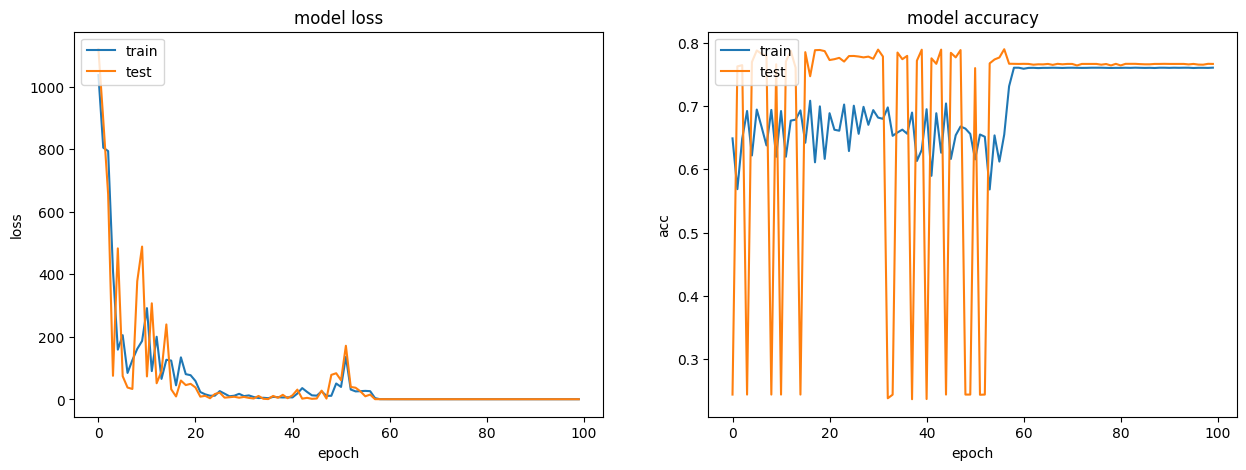

312/312 [==============================] - 1s 2ms/step - loss: 0.5464 - acc: 0.7641
Acuracy:  0.7641149163246155
Predicted     0    1   All
Actual                    
0          7468    8  7476
1          2340  138  2478
All        9808  146  9954


In [13]:
tf.random.set_seed(seed)

model = Sequential()
model.add(Dense(1000, input_dim=14, activation='relu', kernel_initializer="GlorotUniform"))
model.add(Dense(100, activation='relu', kernel_initializer="GlorotUniform"))
model.add(Dense(100, activation='relu' , kernel_initializer="GlorotUniform"))
model.add(Dense(50, activation='relu', kernel_initializer="GlorotUniform"))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])
results = model.fit(X_train, Y_train, validation_split=0.33, epochs=100, batch_size=1000, verbose=0, shuffle=True)
plot_acc_loss(results)

dl_y_pred = (model.predict(X_test) > 0.5).astype("int32")
dl_y_pred = dl_y_pred.flatten()

print("Acuracy: ", model.evaluate(X_test,Y_test)[1])
print(pd.crosstab(Y_test, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

##### Target Group

In [14]:
# Example for sex target groups  
female_pred = []      # Female was label encoded as 0
female_actual_class = []
male_pred = []        # Male was label encoded as 1
male_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[9] == 0:       # Female
        female_pred.append(dl_y_pred[index])
        female_actual_class.append(Y_test[index])
    elif row[9] == 1:     # Male
        male_pred.append(dl_y_pred[index])
        male_actual_class.append(Y_test[index])

# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
subMetrics("Female", female_actual_class, female_pred)
subMetrics("Male", male_actual_class, male_pred)

Metrics for:  Female
Total instances in the test set: 3244
Accuracy: 88.84 %
Predicted     0   1   All
Actual                   
0          2864   1  2865
1           361  18   379
All        3225  19  3244


Metrics for:  Male
Total instances in the test set: 6710
Accuracy: 70.4 %
Predicted     0    1   All
Actual                    
0          4604    7  4611
1          1979  120  2099
All        6583  127  6710




In [15]:
# Target groups of 'race' 
## {[White : 4], [Black : 2], [Asian : 1], [Indian : 0], [Other : 3]}
white_pred = []      
white_actual_class = []
black_pred = []       
black_actual_class = []
asian_pred = []       
asian_actual_class = []
indian_pred = []       
indian_actual_class = []
other_pred = []       
other_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[8] == 4:       # Female
        white_pred.append(dl_y_pred[index])
        white_actual_class.append(Y_test[index])
    elif row[8] == 2:     # Male
        black_pred.append(dl_y_pred[index])
        black_actual_class.append(Y_test[index])
    elif row[8] == 1:     # Male
        asian_pred.append(dl_y_pred[index])
        asian_actual_class.append(Y_test[index])
    elif row[8] == 0:     # Male
        indian_pred.append(dl_y_pred[index])
        indian_actual_class.append(Y_test[index])
    elif row[8] == 3:     # Male
        other_pred.append(dl_y_pred[index])
        other_actual_class.append(Y_test[index])

# Confusion Matrix:
subMetrics("White", white_actual_class, white_pred)
subMetrics("Black", black_actual_class, black_pred)
subMetrics("Asian", asian_actual_class, asian_pred)
subMetrics("Indian", indian_actual_class, indian_pred)
subMetrics("Other", other_actual_class, other_pred)

Metrics for:  White
Total instances in the test set: 8604
Accuracy: 75.16 %
Predicted     0    1   All
Actual                    
0          6341    7  6348
1          2130  126  2256
All        8471  133  8604


Metrics for:  Black
Total instances in the test set: 885
Accuracy: 87.91 %
Predicted    0  1  All
Actual                
0          774  0  774
1          107  4  111
All        881  4  885


Metrics for:  Asian
Total instances in the test set: 302
Accuracy: 71.19 %
Predicted    0  1  All
Actual                
0          210  0  210
1           87  5   92
All        297  5  302


Metrics for:  Indian
Total instances in the test set: 88
Accuracy: 87.5 %
Predicted   0  1  All
Actual               
0          76  1   77
1          10  1   11
All        86  2   88


Metrics for:  Other
Total instances in the test set: 75
Accuracy: 92.0 %
Predicted   0  1  All
Actual               
0          67  0   67
1           6  2    8
All        73  2   75




#### Bias

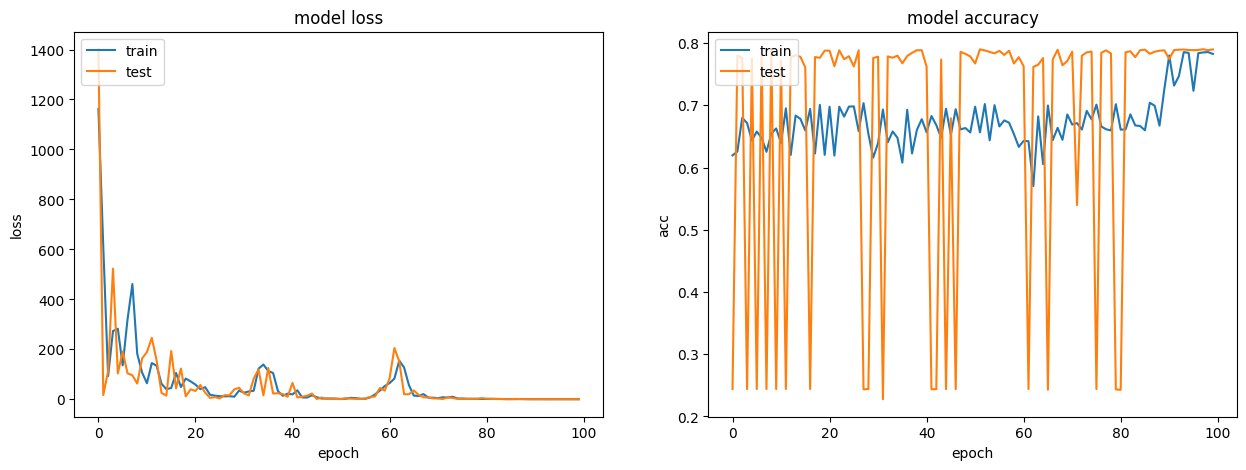

312/312 [==============================] - 1s 2ms/step - loss: 0.5221 - acc: 0.7896
Acuracy:  0.7896323204040527
Predicted     0    1   All
Actual                    
0          7290  186  7476
1          1908  570  2478
All        9198  756  9954


In [16]:
tf.random.set_seed(seed)

model = Sequential()
model.add(Dense(1000, input_dim=14, activation='relu', use_bias = True))
model.add(Dense(100, activation='relu', use_bias = True))
model.add(Dense(100, activation='relu', use_bias = True))
model.add(Dense(50, activation='relu' , use_bias = True))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])
results = model.fit(X_train, Y_train, validation_split=0.33, epochs=100, batch_size=1000, verbose=0, shuffle=True)
plot_acc_loss(results)

dl_y_pred = (model.predict(X_test) > 0.5).astype("int32")
dl_y_pred = dl_y_pred.flatten()

print("Acuracy: ", model.evaluate(X_test,Y_test)[1])
print(pd.crosstab(Y_test, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

##### Target Group

In [17]:
# Example for sex target groups  
female_pred = []      # Female was label encoded as 0
female_actual_class = []
male_pred = []        # Male was label encoded as 1
male_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[9] == 0:       # Female
        female_pred.append(dl_y_pred[index])
        female_actual_class.append(Y_test[index])
    elif row[9] == 1:     # Male
        male_pred.append(dl_y_pred[index])
        male_actual_class.append(Y_test[index])

# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
subMetrics("Female", female_actual_class, female_pred)
subMetrics("Male", male_actual_class, male_pred)

Metrics for:  Female
Total instances in the test set: 3244
Accuracy: 89.3 %
Predicted     0    1   All
Actual                    
0          2803   62  2865
1           285   94   379
All        3088  156  3244


Metrics for:  Male
Total instances in the test set: 6710
Accuracy: 73.96 %
Predicted     0    1   All
Actual                    
0          4487  124  4611
1          1623  476  2099
All        6110  600  6710




In [18]:
# Target groups of 'race' 
## {[White : 4], [Black : 2], [Asian : 1], [Indian : 0], [Other : 3]}
white_pred = []      
white_actual_class = []
black_pred = []       
black_actual_class = []
asian_pred = []       
asian_actual_class = []
indian_pred = []       
indian_actual_class = []
other_pred = []       
other_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[8] == 4:       # Female
        white_pred.append(dl_y_pred[index])
        white_actual_class.append(Y_test[index])
    elif row[8] == 2:     # Male
        black_pred.append(dl_y_pred[index])
        black_actual_class.append(Y_test[index])
    elif row[8] == 1:     # Male
        asian_pred.append(dl_y_pred[index])
        asian_actual_class.append(Y_test[index])
    elif row[8] == 0:     # Male
        indian_pred.append(dl_y_pred[index])
        indian_actual_class.append(Y_test[index])
    elif row[8] == 3:     # Male
        other_pred.append(dl_y_pred[index])
        other_actual_class.append(Y_test[index])

# Confusion Matrix:
subMetrics("White", white_actual_class, white_pred)
subMetrics("Black", black_actual_class, black_pred)
subMetrics("Asian", asian_actual_class, asian_pred)
subMetrics("Indian", indian_actual_class, indian_pred)
subMetrics("Other", other_actual_class, other_pred)

Metrics for:  White
Total instances in the test set: 8604
Accuracy: 77.82 %
Predicted     0    1   All
Actual                    
0          6179  169  6348
1          1739  517  2256
All        7918  686  8604


Metrics for:  Black
Total instances in the test set: 885
Accuracy: 89.27 %
Predicted    0   1  All
Actual                 
0          765   9  774
1           86  25  111
All        851  34  885


Metrics for:  Asian
Total instances in the test set: 302
Accuracy: 75.83 %
Predicted    0   1  All
Actual                 
0          206   4  210
1           69  23   92
All        275  27  302


Metrics for:  Indian
Total instances in the test set: 88
Accuracy: 88.64 %
Predicted   0  1  All
Actual               
0          75  2   77
1           8  3   11
All        83  5   88


Metrics for:  Other
Total instances in the test set: 75
Accuracy: 89.33 %
Predicted   0  1  All
Actual               
0          65  2   67
1           6  2    8
All        71  4   75




#### No Bias

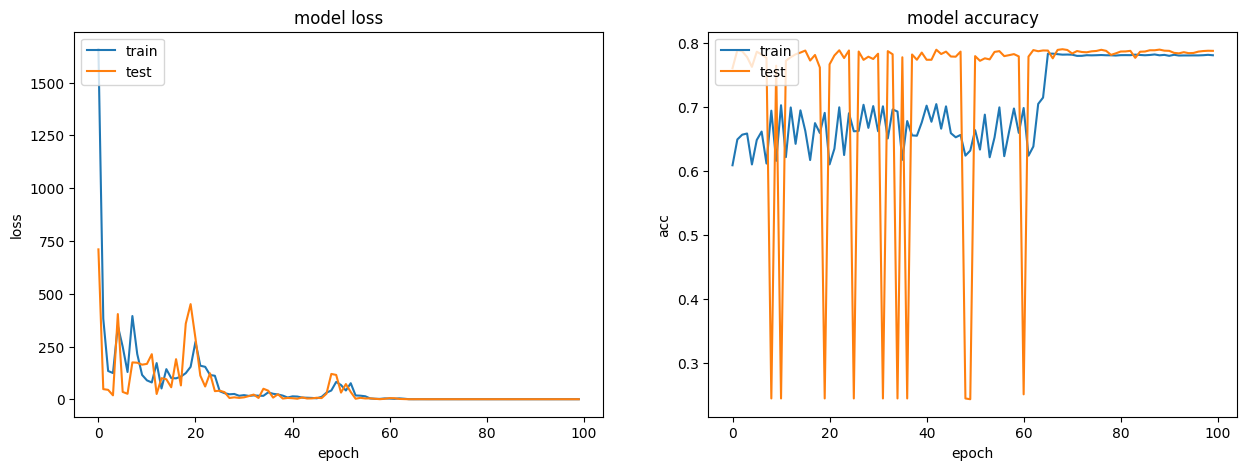

312/312 [==============================] - 1s 2ms/step - loss: 0.5335 - acc: 0.7871
Acuracy:  0.7871207594871521
Predicted     0    1   All
Actual                    
0          7404   72  7476
1          2047  431  2478
All        9451  503  9954


In [19]:
tf.random.set_seed(seed)

model = Sequential()
model.add(Dense(1000, input_dim=14, activation='relu', use_bias = False))
model.add(Dense(100, activation='relu', use_bias = False))
model.add(Dense(100, activation='relu', use_bias = False))
model.add(Dense(50, activation='relu' , use_bias = False))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])
results = model.fit(X_train, Y_train, validation_split=0.33, epochs=100, batch_size=1000, verbose=0, shuffle=True)
plot_acc_loss(results)

dl_y_pred = (model.predict(X_test) > 0.5).astype("int32")
dl_y_pred = dl_y_pred.flatten()

print("Acuracy: ", model.evaluate(X_test,Y_test)[1])
print(pd.crosstab(Y_test, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))
## Probabaly epochs able to stop around 60/70

##### Target Group

In [20]:
# Example for sex target groups  
female_pred = []      # Female was label encoded as 0
female_actual_class = []
male_pred = []        # Male was label encoded as 1
male_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[9] == 0:       # Female
        female_pred.append(dl_y_pred[index])
        female_actual_class.append(Y_test[index])
    elif row[9] == 1:     # Male
        male_pred.append(dl_y_pred[index])
        male_actual_class.append(Y_test[index])

# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
subMetrics("Female", female_actual_class, female_pred)
subMetrics("Male", male_actual_class, male_pred)

Metrics for:  Female
Total instances in the test set: 3244
Accuracy: 89.64 %
Predicted     0   1   All
Actual                   
0          2842  23  2865
1           313  66   379
All        3155  89  3244


Metrics for:  Male
Total instances in the test set: 6710
Accuracy: 73.43 %
Predicted     0    1   All
Actual                    
0          4562   49  4611
1          1734  365  2099
All        6296  414  6710




In [21]:
# Target groups of 'race' 
## {[White : 4], [Black : 2], [Asian : 1], [Indian : 0], [Other : 3]}
white_pred = []      
white_actual_class = []
black_pred = []       
black_actual_class = []
asian_pred = []       
asian_actual_class = []
indian_pred = []       
indian_actual_class = []
other_pred = []       
other_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[8] == 4:       # Female
        white_pred.append(dl_y_pred[index])
        white_actual_class.append(Y_test[index])
    elif row[8] == 2:     # Male
        black_pred.append(dl_y_pred[index])
        black_actual_class.append(Y_test[index])
    elif row[8] == 1:     # Male
        asian_pred.append(dl_y_pred[index])
        asian_actual_class.append(Y_test[index])
    elif row[8] == 0:     # Male
        indian_pred.append(dl_y_pred[index])
        indian_actual_class.append(Y_test[index])
    elif row[8] == 3:     # Male
        other_pred.append(dl_y_pred[index])
        other_actual_class.append(Y_test[index])

# Confusion Matrix:
subMetrics("White", white_actual_class, white_pred)
subMetrics("Black", black_actual_class, black_pred)
subMetrics("Asian", asian_actual_class, asian_pred)
subMetrics("Indian", indian_actual_class, indian_pred)
subMetrics("Other", other_actual_class, other_pred)

Metrics for:  White
Total instances in the test set: 8604
Accuracy: 77.52 %
Predicted     0    1   All
Actual                    
0          6279   69  6348
1          1865  391  2256
All        8144  460  8604


Metrics for:  Black
Total instances in the test set: 885
Accuracy: 89.49 %
Predicted    0   1  All
Actual                 
0          774   0  774
1           93  18  111
All        867  18  885


Metrics for:  Asian
Total instances in the test set: 302
Accuracy: 74.83 %
Predicted    0   1  All
Actual                 
0          209   1  210
1           75  17   92
All        284  18  302


Metrics for:  Indian
Total instances in the test set: 88
Accuracy: 88.64 %
Predicted   0  1  All
Actual               
0          75  2   77
1           8  3   11
All        83  5   88


Metrics for:  Other
Total instances in the test set: 75
Accuracy: 92.0 %
Predicted   0  1  All
Actual               
0          67  0   67
1           6  2    8
All        73  2   75




### Co-adaption

#### Dropout
- test the function with non normalized data and normalized data to see the difference.

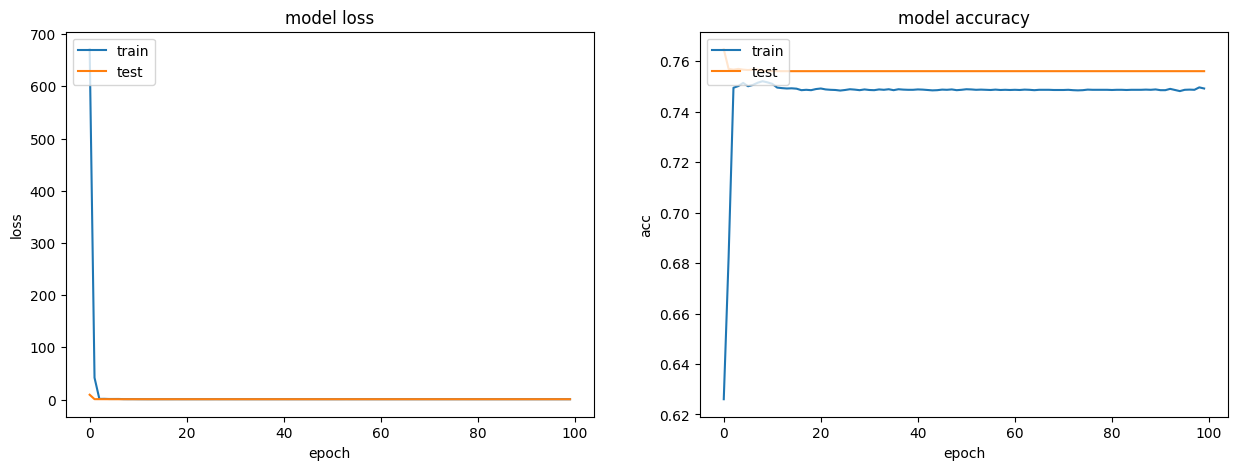

312/312 [==============================] - 1s 2ms/step - loss: 0.5615 - acc: 0.7511
Acuracy:  0.7510548233985901
Predicted     0   All
Actual               
0          7476  7476
1          2478  2478
All        9954  9954


In [22]:
tf.random.set_seed(seed)

model = Sequential()
model.add(Dropout(0.2, input_shape =(14,)))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])
results = model.fit(X_train, Y_train, validation_split=0.33, epochs=100, batch_size=1000, verbose=0, shuffle=True)
plot_acc_loss(results)

dl_y_pred = (model.predict(X_test) > 0.5).astype("int32")
dl_y_pred = dl_y_pred.flatten()

print("Acuracy: ", model.evaluate(X_test,Y_test)[1])
print(pd.crosstab(Y_test, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

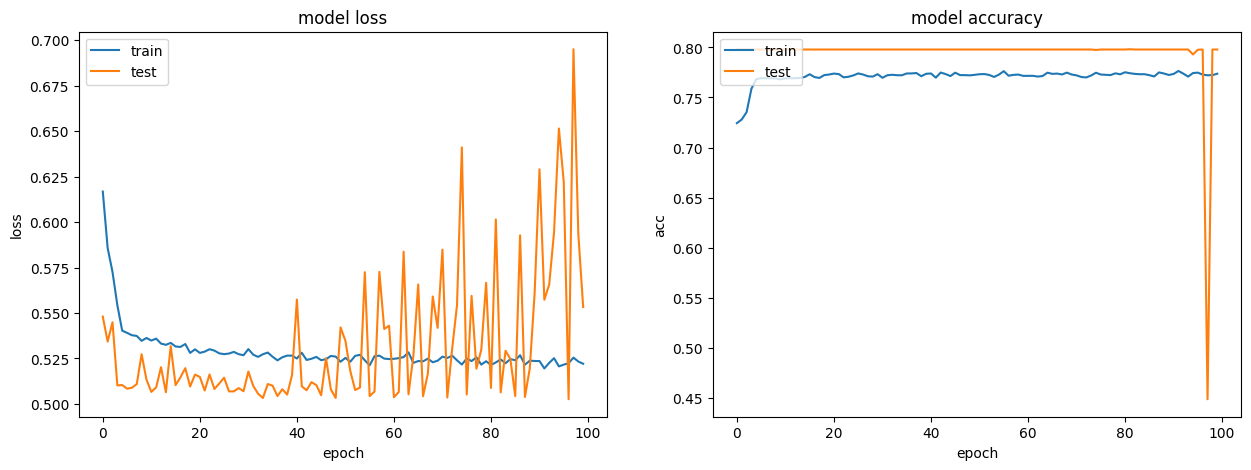

312/312 [==============================] - 1s 2ms/step - loss: 33923.6680 - acc: 0.7736
Acuracy:  0.7735583782196045
Predicted     0    1   All
Actual                    
0          7437   39  7476
1          2215  263  2478
All        9652  302  9954


In [23]:
# Dropout model with normalized data
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed) 

scaler = preprocessing.Normalizer().fit(X)
normalizedX = scaler.transform(X)

model = Sequential()
model.add(Dropout(0.2, input_shape =(14,)))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


# Compile model
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])

# Fit the model, but this time store the history (that is accuracy and loss for each Epoch)
results = model.fit(normalizedX, Y, validation_split=0.33, epochs=100, batch_size=1000, verbose=0, shuffle=True)
plot_acc_loss(results)

dl_y_pred = (model.predict(X_test) > 0.5).astype("int32")
dl_y_pred = dl_y_pred.flatten()

print("Acuracy: ", model.evaluate(X_test,Y_test)[1])
print(pd.crosstab(Y_test, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

##### Target Group

In [24]:
# Example for sex target groups  
female_pred = []      # Female was label encoded as 0
female_actual_class = []
male_pred = []        # Male was label encoded as 1
male_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[9] == 0:       # Female
        female_pred.append(dl_y_pred[index])
        female_actual_class.append(Y_test[index])
    elif row[9] == 1:     # Male
        male_pred.append(dl_y_pred[index])
        male_actual_class.append(Y_test[index])

# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
subMetrics("Female", female_actual_class, female_pred)
subMetrics("Male", male_actual_class, male_pred)

Metrics for:  Female
Total instances in the test set: 3244
Accuracy: 89.21 %
Predicted     0   1   All
Actual                   
0          2857   8  2865
1           342  37   379
All        3199  45  3244


Metrics for:  Male
Total instances in the test set: 6710
Accuracy: 71.62 %
Predicted     0    1   All
Actual                    
0          4580   31  4611
1          1873  226  2099
All        6453  257  6710




In [25]:
# Target groups of 'race' 
## {[White : 4], [Black : 2], [Asian : 1], [Indian : 0], [Other : 3]}
white_pred = []      
white_actual_class = []
black_pred = []       
black_actual_class = []
asian_pred = []       
asian_actual_class = []
indian_pred = []       
indian_actual_class = []
other_pred = []       
other_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[8] == 4:       # Female
        white_pred.append(dl_y_pred[index])
        white_actual_class.append(Y_test[index])
    elif row[8] == 2:     # Male
        black_pred.append(dl_y_pred[index])
        black_actual_class.append(Y_test[index])
    elif row[8] == 1:     # Male
        asian_pred.append(dl_y_pred[index])
        asian_actual_class.append(Y_test[index])
    elif row[8] == 0:     # Male
        indian_pred.append(dl_y_pred[index])
        indian_actual_class.append(Y_test[index])
    elif row[8] == 3:     # Male
        other_pred.append(dl_y_pred[index])
        other_actual_class.append(Y_test[index])

# Confusion Matrix:
subMetrics("White", white_actual_class, white_pred)
subMetrics("Black", black_actual_class, black_pred)
subMetrics("Asian", asian_actual_class, asian_pred)
subMetrics("Indian", indian_actual_class, indian_pred)
subMetrics("Other", other_actual_class, other_pred)

Metrics for:  White
Total instances in the test set: 8604
Accuracy: 76.1 %
Predicted     0    1   All
Actual                    
0          6311   37  6348
1          2019  237  2256
All        8330  274  8604


Metrics for:  Black
Total instances in the test set: 885
Accuracy: 88.47 %
Predicted    0   1  All
Actual                 
0          773   1  774
1          101  10  111
All        874  11  885


Metrics for:  Asian
Total instances in the test set: 302
Accuracy: 73.18 %
Predicted    0   1  All
Actual                 
0          210   0  210
1           81  11   92
All        291  11  302


Metrics for:  Indian
Total instances in the test set: 88
Accuracy: 89.77 %
Predicted   0  1  All
Actual               
0          76  1   77
1           8  3   11
All        84  4   88


Metrics for:  Other
Total instances in the test set: 75
Accuracy: 92.0 %
Predicted   0  1  All
Actual               
0          67  0   67
1           6  2    8
All        73  2   75




#### Noise

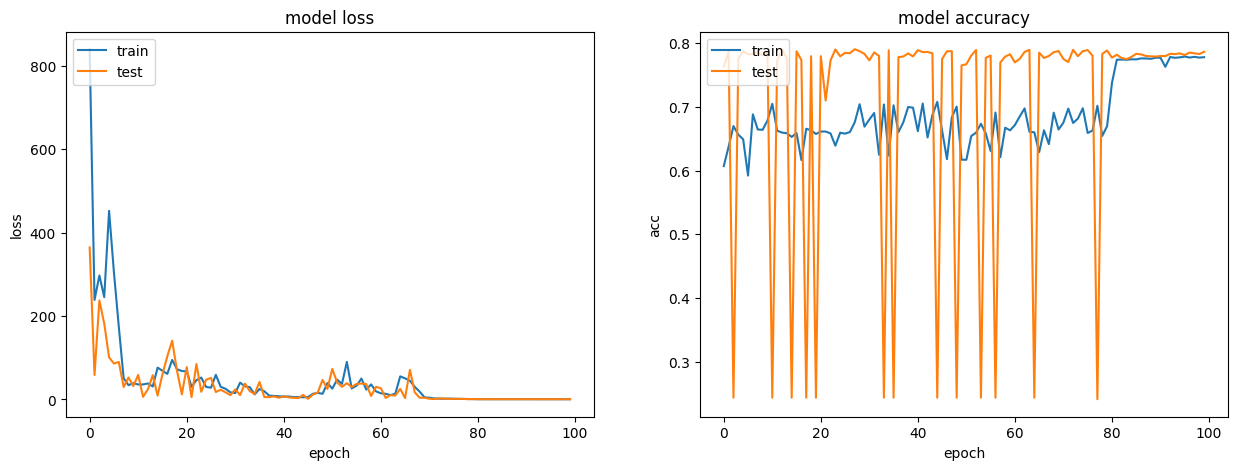

312/312 [==============================] - 1s 2ms/step - loss: 0.5419 - acc: 0.7857
Acuracy:  0.7857142686843872
Predicted     0    1   All
Actual                    
0          7271  205  7476
1          1928  550  2478
All        9199  755  9954


In [26]:
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

model = Sequential()
model.add(Dense(1000, input_dim=14, activation='relu'))
model.add(GaussianNoise(0.1))
model.add(Dense(100, activation='relu'))
model.add(GaussianNoise(0.1))
model.add(Dense(100, activation='relu'))
model.add(GaussianNoise(0.1))
model.add(Dense(50, activation='relu'))
model.add(GaussianNoise(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])
results = model.fit(X_train, Y_train, validation_split=0.33, epochs=100, batch_size=1000, verbose=0, shuffle=True)
plot_acc_loss(results)

dl_y_pred = (model.predict(X_test) > 0.5).astype("int32")
dl_y_pred = dl_y_pred.flatten()

print("Acuracy: ", model.evaluate(X_test,Y_test)[1])
print(pd.crosstab(Y_test, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))

##### Target Group

In [27]:
# Example for sex target groups  
female_pred = []      # Female was label encoded as 0
female_actual_class = []
male_pred = []        # Male was label encoded as 1
male_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[9] == 0:       # Female
        female_pred.append(dl_y_pred[index])
        female_actual_class.append(Y_test[index])
    elif row[9] == 1:     # Male
        male_pred.append(dl_y_pred[index])
        male_actual_class.append(Y_test[index])

# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
subMetrics("Female", female_actual_class, female_pred)
subMetrics("Male", male_actual_class, male_pred)

Metrics for:  Female
Total instances in the test set: 3244
Accuracy: 88.81 %
Predicted     0    1   All
Actual                    
0          2801   64  2865
1           299   80   379
All        3100  144  3244


Metrics for:  Male
Total instances in the test set: 6710
Accuracy: 73.62 %
Predicted     0    1   All
Actual                    
0          4470  141  4611
1          1629  470  2099
All        6099  611  6710




In [28]:
# Target groups of 'race' 
## {[White : 4], [Black : 2], [Asian : 1], [Indian : 0], [Other : 3]}
white_pred = []      
white_actual_class = []
black_pred = []       
black_actual_class = []
asian_pred = []       
asian_actual_class = []
indian_pred = []       
indian_actual_class = []
other_pred = []       
other_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[8] == 4:       # Female
        white_pred.append(dl_y_pred[index])
        white_actual_class.append(Y_test[index])
    elif row[8] == 2:     # Male
        black_pred.append(dl_y_pred[index])
        black_actual_class.append(Y_test[index])
    elif row[8] == 1:     # Male
        asian_pred.append(dl_y_pred[index])
        asian_actual_class.append(Y_test[index])
    elif row[8] == 0:     # Male
        indian_pred.append(dl_y_pred[index])
        indian_actual_class.append(Y_test[index])
    elif row[8] == 3:     # Male
        other_pred.append(dl_y_pred[index])
        other_actual_class.append(Y_test[index])

# Confusion Matrix:
subMetrics("White", white_actual_class, white_pred)
subMetrics("Black", black_actual_class, black_pred)
subMetrics("Asian", asian_actual_class, asian_pred)
subMetrics("Indian", indian_actual_class, indian_pred)
subMetrics("Other", other_actual_class, other_pred)

Metrics for:  White
Total instances in the test set: 8604
Accuracy: 77.5 %
Predicted     0    1   All
Actual                    
0          6165  183  6348
1          1753  503  2256
All        7918  686  8604


Metrics for:  Black
Total instances in the test set: 885
Accuracy: 88.02 %
Predicted    0   1  All
Actual                 
0          758  16  774
1           90  21  111
All        848  37  885


Metrics for:  Asian
Total instances in the test set: 302
Accuracy: 75.17 %
Predicted    0   1  All
Actual                 
0          206   4  210
1           71  21   92
All        277  25  302


Metrics for:  Indian
Total instances in the test set: 88
Accuracy: 89.77 %
Predicted   0  1  All
Actual               
0          76  1   77
1           8  3   11
All        84  4   88


Metrics for:  Other
Total instances in the test set: 75
Accuracy: 90.67 %
Predicted   0  1  All
Actual               
0          66  1   67
1           6  2    8
All        72  3   75




### Callbacks
- Automatically saving weights and early stopping


Epoch 1: acc improved from -inf to 0.60721, saving model to myBest.hdf5

Epoch 2: acc improved from 0.60721 to 0.60906, saving model to myBest.hdf5

Epoch 3: acc improved from 0.60906 to 0.66423, saving model to myBest.hdf5

Epoch 4: acc improved from 0.66423 to 0.67523, saving model to myBest.hdf5

Epoch 5: acc did not improve from 0.67523

Epoch 6: acc did not improve from 0.67523

Epoch 7: acc did not improve from 0.67523

Epoch 8: acc did not improve from 0.67523


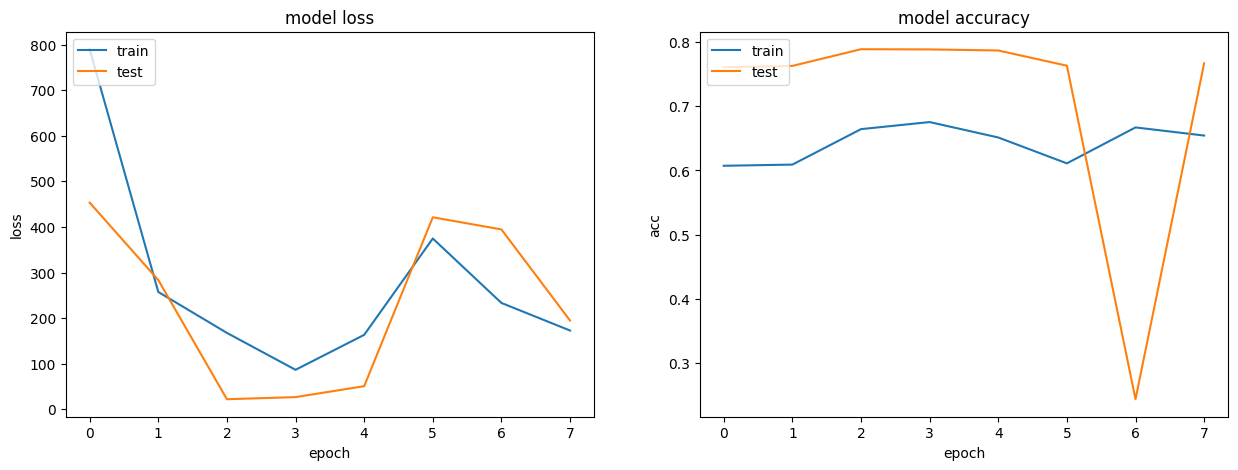

312/312 [==============================] - 1s 2ms/step - loss: 198.2879 - acc: 0.7650
Acuracy:  0.7650190591812134
Predicted     0    1   All
Actual                    
0          7467    9  7476
1          2330  148  2478
All        9797  157  9954


In [29]:
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed) # for TF this needs to be run per cell.


model = Sequential()
model.add(Dense(1000, input_dim=14, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


# Compile model
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['acc'])

# Checkpointing
checkpoint = ModelCheckpoint("myBest.hdf5", monitor='acc', save_best_only=True, mode="max", verbose=1)
earlystopping = EarlyStopping(monitor="val_loss",patience= 5)


callbacks_list = [checkpoint, earlystopping]

# Fit the model, but this time store the history (that is accuracy and loss for each Epoch)
results = model.fit(X_train, Y_train, validation_split=0.33, epochs=100, batch_size=1000, verbose=0, shuffle=True, callbacks=callbacks_list)
plot_acc_loss(results)

dl_y_pred = (model.predict(X_test) > 0.5).astype("int32")
dl_y_pred = dl_y_pred.flatten()

print("Acuracy: ", model.evaluate(X_test,Y_test)[1])
print(pd.crosstab(Y_test, dl_y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True))


##### Target Group

In [30]:
# Example for sex target groups  
female_pred = []      # Female was label encoded as 0
female_actual_class = []
male_pred = []        # Male was label encoded as 1
male_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[9] == 0:       # Female
        female_pred.append(dl_y_pred[index])
        female_actual_class.append(Y_test[index])
    elif row[9] == 1:     # Male
        male_pred.append(dl_y_pred[index])
        male_actual_class.append(Y_test[index])

# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
subMetrics("Female", female_actual_class, female_pred)
subMetrics("Male", male_actual_class, male_pred)

Metrics for:  Female
Total instances in the test set: 3244
Accuracy: 88.87 %
Predicted     0   1   All
Actual                   
0          2864   1  2865
1           360  19   379
All        3224  20  3244


Metrics for:  Male
Total instances in the test set: 6710
Accuracy: 70.52 %
Predicted     0    1   All
Actual                    
0          4603    8  4611
1          1970  129  2099
All        6573  137  6710




In [31]:
# Target groups of 'race' 
## {[White : 4], [Black : 2], [Asian : 1], [Indian : 0], [Other : 3]}
white_pred = []      
white_actual_class = []
black_pred = []       
black_actual_class = []
asian_pred = []       
asian_actual_class = []
indian_pred = []       
indian_actual_class = []
other_pred = []       
other_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[8] == 4:       # Female
        white_pred.append(dl_y_pred[index])
        white_actual_class.append(Y_test[index])
    elif row[8] == 2:     # Male
        black_pred.append(dl_y_pred[index])
        black_actual_class.append(Y_test[index])
    elif row[8] == 1:     # Male
        asian_pred.append(dl_y_pred[index])
        asian_actual_class.append(Y_test[index])
    elif row[8] == 0:     # Male
        indian_pred.append(dl_y_pred[index])
        indian_actual_class.append(Y_test[index])
    elif row[8] == 3:     # Male
        other_pred.append(dl_y_pred[index])
        other_actual_class.append(Y_test[index])

# Confusion Matrix:
subMetrics("White", white_actual_class, white_pred)
subMetrics("Black", black_actual_class, black_pred)
subMetrics("Asian", asian_actual_class, asian_pred)
subMetrics("Indian", indian_actual_class, indian_pred)
subMetrics("Other", other_actual_class, other_pred)

Metrics for:  White
Total instances in the test set: 8604
Accuracy: 75.27 %
Predicted     0    1   All
Actual                    
0          6340    8  6348
1          2120  136  2256
All        8460  144  8604


Metrics for:  Black
Total instances in the test set: 885
Accuracy: 87.91 %
Predicted    0  1  All
Actual                
0          774  0  774
1          107  4  111
All        881  4  885


Metrics for:  Asian
Total instances in the test set: 302
Accuracy: 71.19 %
Predicted    0  1  All
Actual                
0          210  0  210
1           87  5   92
All        297  5  302


Metrics for:  Indian
Total instances in the test set: 88
Accuracy: 87.5 %
Predicted   0  1  All
Actual               
0          76  1   77
1          10  1   11
All        86  2   88


Metrics for:  Other
Total instances in the test set: 75
Accuracy: 92.0 %
Predicted   0  1  All
Actual               
0          67  0   67
1           6  2    8
All        73  2   75




### Grid Search

In [32]:
# Function (Step) of model for training
def gs_model(optimizerIn='adam', initIn='GlorotUniform'):
    model = Sequential()
    model.add(Dense(1000, input_dim=14, activation='relu', kernel_initializer=initIn))
    model.add(Dense(100, activation='relu', kernel_initializer=initIn))
    model.add(Dense(100, activation='relu', kernel_initializer=initIn))
    model.add(Dense(50, activation='relu' , kernel_initializer=initIn))
    model.add(Dense(1, activation='sigmoid'))
     # Compile model
    model.compile(loss='binary_crossentropy', optimizer=optimizerIn, metrics=['acc'])
    return model

In [33]:
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

model = KerasClassifier(build_fn=gs_model)

# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam']
inits = ['normal', 'uniform']
epochs = [100]
batches = [1000, 2000]


# Checkpointing
checkpoint = ModelCheckpoint("myBest.hdf5", monitor='acc', save_best_only=True, mode="max", verbose=0)
earlystopping = EarlyStopping(monitor="loss",patience= 5)
callbacks_list = [checkpoint, earlystopping]


param_grid = dict(optimizerIn=optimizers, epochs=epochs, batch_size=batches, initIn=inits)

grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, Y_train, callbacks=callbacks_list)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/100


<ipython-input-33-54d30725ee25>:5: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=gs_model)


17/17 [==============================] - 2s 6ms/step - loss: 617.3002 - acc: 0.5649
Epoch 2/100
17/17 [==============================] - 0s 6ms/step - loss: 112.4719 - acc: 0.6260
Epoch 3/100
17/17 [==============================] - 0s 6ms/step - loss: 87.3513 - acc: 0.6310
Epoch 4/100
17/17 [==============================] - 0s 5ms/step - loss: 77.0318 - acc: 0.6340
Epoch 5/100
17/17 [==============================] - 0s 5ms/step - loss: 9.3316 - acc: 0.7139
Epoch 6/100
17/17 [==============================] - 0s 5ms/step - loss: 0.6829 - acc: 0.7410
Epoch 7/100
17/17 [==============================] - 0s 6ms/step - loss: 0.6604 - acc: 0.7702
Epoch 8/100
17/17 [==============================] - 0s 4ms/step - loss: 28.6505 - acc: 0.7024
Epoch 9/100
17/17 [==============================] - 0s 4ms/step - loss: 0.6414 - acc: 0.7702
Epoch 10/100
17/17 [==============================] - 0s 6ms/step - loss: 0.6314 - acc: 0.7705
Epoch 11/100
17/17 [==============================] - 0s 4ms/ste

3/3 [==============================] - 0s 9ms/step - loss: 58.7616 - acc: 0.7590
Epoch 1/100
9/9 [==============================] - 1s 5ms/step - loss: 892.6956 - acc: 0.5704
Epoch 2/100
9/9 [==============================] - 0s 4ms/step - loss: 299.9717 - acc: 0.5681
Epoch 3/100
9/9 [==============================] - 0s 4ms/step - loss: 168.5157 - acc: 0.6279
Epoch 4/100
9/9 [==============================] - 0s 5ms/step - loss: 166.3729 - acc: 0.5672
Epoch 5/100
9/9 [==============================] - 0s 4ms/step - loss: 74.7264 - acc: 0.6351
Epoch 6/100
9/9 [==============================] - 0s 5ms/step - loss: 52.0562 - acc: 0.6348
Epoch 7/100
9/9 [==============================] - 0s 5ms/step - loss: 76.1324 - acc: 0.6337
Epoch 8/100
9/9 [==============================] - 0s 4ms/step - loss: 51.5269 - acc: 0.5710
Epoch 9/100
9/9 [==============================] - 0s 5ms/step - loss: 105.5869 - acc: 0.5724
Epoch 10/100
9/9 [==============================] - 0s 4ms/step - loss: 49.83

3/3 [==============================] - 0s 6ms/step - loss: 0.8877 - acc: 0.7550
Epoch 1/100
9/9 [==============================] - 2s 5ms/step - loss: 426.1580 - acc: 0.5643
Epoch 2/100
9/9 [==============================] - 0s 5ms/step - loss: 182.1880 - acc: 0.6288
Epoch 3/100
9/9 [==============================] - 0s 5ms/step - loss: 116.3053 - acc: 0.6340
Epoch 4/100
9/9 [==============================] - 0s 5ms/step - loss: 110.2285 - acc: 0.6262
Epoch 5/100
9/9 [==============================] - 0s 5ms/step - loss: 148.0804 - acc: 0.5646
Epoch 6/100
9/9 [==============================] - 0s 5ms/step - loss: 164.1300 - acc: 0.6355
Epoch 7/100
9/9 [==============================] - 0s 5ms/step - loss: 43.3834 - acc: 0.6358
Epoch 8/100
9/9 [==============================] - 0s 5ms/step - loss: 66.6739 - acc: 0.6345
Epoch 9/100
9/9 [==============================] - 0s 5ms/step - loss: 57.3822 - acc: 0.6267
Epoch 10/100
9/9 [==============================] - 0s 5ms/step - loss: 33.40

##### Target Group

In [35]:
# Example for sex target groups  
female_pred = []      # Female was label encoded as 0
female_actual_class = []
male_pred = []        # Male was label encoded as 1
male_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[9] == 0:       # Female
        female_pred.append(dl_y_pred[index])
        female_actual_class.append(Y_test[index])
    elif row[9] == 1:     # Male
        male_pred.append(dl_y_pred[index])
        male_actual_class.append(Y_test[index])

# Confusion Matrix:
# overall TP, FP, TN, FN values, for binary values only
subMetrics("Female", female_actual_class, female_pred)
subMetrics("Male", male_actual_class, male_pred)

Metrics for:  Female
Total instances in the test set: 3244
Accuracy: 88.87 %
Predicted     0   1   All
Actual                   
0          2864   1  2865
1           360  19   379
All        3224  20  3244


Metrics for:  Male
Total instances in the test set: 6710
Accuracy: 70.52 %
Predicted     0    1   All
Actual                    
0          4603    8  4611
1          1970  129  2099
All        6573  137  6710




In [34]:
# Target groups of 'race' 
## {[White : 4], [Black : 2], [Asian : 1], [Indian : 0], [Other : 3]}
white_pred = []      
white_actual_class = []
black_pred = []       
black_actual_class = []
asian_pred = []       
asian_actual_class = []
indian_pred = []       
indian_actual_class = []
other_pred = []       
other_actual_class = []

# Populate the confusion matrix grouping by gender (col index 9) you could also do this via group by but would need to convert back to pandas dataframe.
# When grouping by multi class, you will have to modify the below code to include multi class, as for this example there is only two. 
# Also we are using the DT algorithm here, you can change this to DL if you selected that algorithm. 
for index,row in enumerate(X_test):
    if row[8] == 4:       # Female
        white_pred.append(dl_y_pred[index])
        white_actual_class.append(Y_test[index])
    elif row[8] == 2:     # Male
        black_pred.append(dl_y_pred[index])
        black_actual_class.append(Y_test[index])
    elif row[8] == 1:     # Male
        asian_pred.append(dl_y_pred[index])
        asian_actual_class.append(Y_test[index])
    elif row[8] == 0:     # Male
        indian_pred.append(dl_y_pred[index])
        indian_actual_class.append(Y_test[index])
    elif row[8] == 3:     # Male
        other_pred.append(dl_y_pred[index])
        other_actual_class.append(Y_test[index])

# Confusion Matrix:
subMetrics("White", white_actual_class, white_pred)
subMetrics("Black", black_actual_class, black_pred)
subMetrics("Asian", asian_actual_class, asian_pred)
subMetrics("Indian", indian_actual_class, indian_pred)
subMetrics("Other", other_actual_class, other_pred)

Metrics for:  White
Total instances in the test set: 8604
Accuracy: 75.27 %
Predicted     0    1   All
Actual                    
0          6340    8  6348
1          2120  136  2256
All        8460  144  8604


Metrics for:  Black
Total instances in the test set: 885
Accuracy: 87.91 %
Predicted    0  1  All
Actual                
0          774  0  774
1          107  4  111
All        881  4  885


Metrics for:  Asian
Total instances in the test set: 302
Accuracy: 71.19 %
Predicted    0  1  All
Actual                
0          210  0  210
1           87  5   92
All        297  5  302


Metrics for:  Indian
Total instances in the test set: 88
Accuracy: 87.5 %
Predicted   0  1  All
Actual               
0          76  1   77
1          10  1   11
All        86  2   88


Metrics for:  Other
Total instances in the test set: 75
Accuracy: 92.0 %
Predicted   0  1  All
Actual               
0          67  0   67
1           6  2    8
All        73  2   75


